# Economic Module Simulation (PoW)

## Objective

The simulation models the dynamics of a blockchain network under a Proof-of-Work PoW) consensus. It captures the interaction between agents, economic
parameters, and macroeconomic metrics such as token price, liquidity, and adoption. While certain system parameters—like APY thresholds, token allocations,
and role-based reward shares—are predefined, agent behaviours directly influence network activity and key economic indicators. The simulation remains
fundamentally agent-centric, with agents ranked by their computed scores, which determine their share of predefined rewards across discrete epochs.


## Project map (what each script does)

This simulation is modular — each file has a clear role.  
Here’s the overview:

### `Economic_Model_Simulation-merged.py` (entrypoint / runner)
- Orchestrates the **cadCAD experiment**: builds config, runs the simulation, collects results, and triggers plots.

### `agents.py` (agent factory & behaviors)
- Defines **agent roles** (user, developer, miner, bundler).
- Encodes behaviors like making transactions, adding/removing liquidity, mining, and bundling.
- Provides utilities to create an initial agent population.

### `states.py` (system state variables)
- Declares the simulation **state dictionary**: balances, pools, tx queues, reward buckets, governance weights.
- Provides initialization logic and derived macro fields (APY, velocity, adoption, etc.).

### `network_config.py` (topology & connectivity)
- Configures **relationships** among agents/roles.
- Includes structures for token allocations, activities, reward pools.

### `params.py` (parameters)
- Central **knobs & levers**: fees, reward shares, activity thresholds, governance targets, token distribution.
- Adjust here to change behavior instead of touching logic.

### `sim_config.py` (cadCAD setup)
- Wraps cadCAD **experiment definition**: PSUBs, policies, state updates, initial state, simulation horizon.

### `seeded_random.py` (reproducible RNG)
- Provides a **seeded random generator** so stochastic runs are deterministic when re-run.

### `score_model.py` (scoring & rewards)
- Defines **scoring model**: computes role/agent scores.
- Applies reward allocation rules (tiers, governance multipliers, activity weights).
- Critical for distributing pool rewards fairly.


### `calculator.py` (economic calculations) :contentReference[oaicite:0]{index=0}
- Core class: `NetworkCalculator`.
- Computes **macro-economic metrics** from micro-level activity.
- Handles:
  - Token price dynamics (supply vs demand imbalance).
  - Token velocity (tx, reward, fee).
  - Circulating vs effective supply updates.
  - Release schedules, vesting, and cliff logic.
  - LP APY with smoothing (`LP_APY_SMOOTHING_LAMBDA`).
- Produces derived metrics: market cap, FDV, maturity, fee sustainability, etc.

### `metrics.py` (performance & KPIs) :contentReference[oaicite:1]{index=1}
- Provides **dataclasses** for tracking results:
  - `RolePerformanceMetrics` → per-strategy stats (fees, rewards, efficiency).
  - `NetworkMetrics` → global KPIs (token velocity, fees, rewards, role distribution).
- Tracks:
  - Transaction volume, fees, unique participants.
  - Role participation and balances.
  - Strategy-level performance and payoffs (for game-theory analysis).
- Supports **historical trend analysis** and **payoff matrix generation** for equilibrium studies.

### `allocation_config.py` (token allocations) :contentReference[oaicite:2]{index=2}
- Defines the **initial token supply split** into categories:
  - Public sale, airdrop, team, investors, treasury, ecosystem, reserves.
- Encodes **vesting & cliff schedules** (e.g., team → 12-month cliff, 24-month vesting).
- Feeds into the calculator for circulating/vesting supply logic.

---

> 📌 **Tip for readers:**  
> Together, these modules form the loop:  
> **Params → Agents → States → Network/Allocations → Score Model → Calculator → Metrics → Results.**


### 1) Imports (what each group is for)

- **cadCAD**: experiment/scenario runner (`Experiment`, `ExecutionMode`, PSUBs utils).  
- **Project modules**: `network_config`, `states`, `metrics`, `allocation_config`.  
- **Utils**: `pandas` for results, `pathlib` for paths, `json` for config.


In [1]:
from cadCAD.configuration.utils import config_sim
from cadCAD.configuration import Experiment
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
from cadCAD.utils.execution import print_exec_info

import pandas as pd
from pathlib import Path
import json
import matplotlib.pyplot as plt
from collections import defaultdict

from logic.network_config import load_configuration
from logic.states import initialize_system_state, SystemState
from logic.metrics import NetworkMetrics
from itertools import product
from logic.allocation_config import allocations

### 2) Load Configuration json File with initial variables
**Config basics.**  
`default_config.json` sets high-level knobs (epochs, agent counts, fees, activity weights, price params).  
Keeping these in JSON makes runs reproducible and easy to diff in GitHub PRs.


In [3]:
CONFIG_PATH = Path("json/default_config.json")
network_config = load_configuration(CONFIG_PATH)


### 3) Simulation Configuration

In this section, we define the **parameters and setup** for our cadCAD simulation.  

- **λ (lambda)** → smoothing factor, controls the exponential smoothing applied to agent scores over epochs. It blends the current normalized activity score with the previous score to stabilize reward distribution dynamics.
- **β (beta)** → Used in the governance multiplier update rule. It defines how sensitively the multiplier for each activity reacts to the difference between the desired share Dₐ) and the observed share Tₐ) of that activity.
- **D vector** → Defines the target activity distribution across different agent behaviors, such as transfer_tokens and provide_liquidity . Adjusting this vector directly influences which activities the network prioritizes and incentivizes during the simulation.
 
We then:
1. Combine these parameters into a Cartesian product (`sweep`) so cadCAD can run multiple parameter scenarios.  
2. Initialize the system epochs (how many time steps to simulate).  
3. Build a cadCAD-compatible configuration object (`raw_sim_config`) that links all parameters to the simulation engine.


### 4) Experiment Variables (tuning knobs)

In this section, we define the **core parameters** we will vary between simulation runs. These act as the *control knobs* of the economic model:

In [ ]:
# Parameters
lambda_values = [0.2]
beta_values = [0.8]

# Only one D vector
d_vectors = [
    {"transfer_tokens": 0.6, "provide_liquidity": 0.4}
]

In [5]:
# Cartesian product with only one combination
sweep = list(product(lambda_values, beta_values, d_vectors))

# Initialize simulation epochs
sim_epochs = initialize_system_state(network_config, allocations)[0].epochs

# Build cadCAD-compatible simulation config
raw_sim_config = {
    "N": 1,
    "T": range(sim_epochs),
    "M": {
        "lambda_smoothing": [lam for lam, _, _ in sweep],
        "beta_fixed": [beta for _, beta, _ in sweep],
        "custom_D_values": [d_vec for _, _, d_vec in sweep]
    }
}

# Final config for cadCAD
sim_config = config_sim(raw_sim_config)


✅ TGE Circulating Supply computed: 2000000.0
System State Initialized.
Total Supply (fixed): 10000000
TGE Circulating Supply: 2000000.0
user: 180 agents (60.0%)
developer: 60 agents (20.0%)
bundler: 30 agents (10.0%)
miner: 30 agents (10.0%)
Validation Details:
Block Height: 0
Total Supply: 10000000
Circulating Supply: 2000000.0
Total Agent Balance: 2000000.0
Total Pool Balance: 0.0
Sum: 2000000.0
Difference: 0.0


### 5) Simulation pipeline (at a glance)

1. **Initialize**  
   Load parameters → create agents → set initial state.

2. **Step loop** (for each timestep/epoch)  
   - Apply **policies** (agent actions & exogenous events).  
   - Apply **state updates** (aggregate effects into new state).  
   - Compute **scores/rewards** and **derived metrics** (APY, velocity, adoption).

3. **Collect results**  
   Concatenate timestep data → produce tables & plots → interpret.



In [7]:
# ✅ Used in the policy block
def inject_params_policy(params, step, sL, s):
    return {
        "lambda_smoothing": params["lambda_smoothing"],
        "beta_fixed": params["beta_fixed"],
        "custom_D_values": params["custom_D_values"],  
    }

def apply_injected_params(params, step, sL, s, _input):
    # ✅ Do NOT reset the system
    system = s["system"]
    system.lambda_smoothing = _input["lambda_smoothing"]
    system.beta_fixed = _input["beta_fixed"]
    system.config.custom_D_values = _input["custom_D_values"]

    s["lambda"] = _input["lambda_smoothing"]
    s["beta"] = _input["beta_fixed"]
    s["D"] = _input["custom_D_values"]

    return "system", system






### 6) cadCAD blocks (policies & state updates)

cadCAD processes each timestep in two phases:

- **Policies** (propose): compute *candidate* changes from inputs/params/agent actions.  
- **State Updates** (apply): deterministically update the system state using policy outputs.

Below:
- `inject_params_policy` → passes λ, β, and D into the system each step.  
- `apply_injected_params` → writes them into `system` without resetting state.  
- `no_op_policy` → a placeholder to advance the clock cleanly.  
- `system_state_update` → your core step logic; also snapshots `metrics` for analysis.


In [9]:
def no_op_policy(params, step, sL, s):
    return {}

def system_state_update(params, step, sL, s, _input):
    system = s['system']
    system.update_epoch()
    metrics_snapshot = dict(system.metrics)  # Take a snapshot (shallow copy) of metrics
    return {
        'system': system,
        'supply_metrics': metrics_snapshot  
    }


In [11]:
partial_state_update_blocks = [
    {
        "policies": {
            "inject": inject_params_policy
        },
        "states": {
            "system": apply_injected_params 
        }
    },
    {
        "policies": {
            "noop": no_op_policy
        },
        "states": {
            # ✅ split the dict manually
            "system": lambda params, step, sL, s, _input: ("system", system_state_update(params, step, sL, s, _input)["system"]),
            "supply_metrics": lambda params, step, sL, s, _input: ("supply_metrics", system_state_update(params, step, sL, s, _input)["supply_metrics"]),
        }
    }
]


### 7) Initial state

We seed cadCAD with:
- `system`: the full `SystemState` from `initialize_system_state(...)`.  
- `supply_metrics`: empty dict that will be filled at each step.  
- Placeholders for injected params (`lambda`, `beta`, `D`), set by the policy above.


In [13]:
initial_state = {
    "system": initialize_system_state(network_config, allocations)[0],  
    "supply_metrics": {},
    "lambda": None,
    "beta": None,
    "D": None
}


✅ TGE Circulating Supply computed: 2000000.0
System State Initialized.
Total Supply (fixed): 10000000
TGE Circulating Supply: 2000000.0
user: 180 agents (60.0%)
developer: 60 agents (20.0%)
bundler: 30 agents (10.0%)
miner: 30 agents (10.0%)
Validation Details:
Block Height: 0
Total Supply: 10000000
Circulating Supply: 2000000.0
Total Agent Balance: 2000000.0
Total Pool Balance: 0.0
Sum: 2000000.0
Difference: 0.0


### 8) Register the experiment

We now bind our model definition to a cadCAD `Experiment`.  
- `model_id` is just a label for the run.  
- `initial_state` seeds the system.  
- `partial_state_update_blocks` defines the step logic (policies → state updates).  
- `sim_configs` carries our parameters/sweep.


In [15]:
exp = Experiment()
exp.append_model(
    model_id="Incentiv_Economic_Model",
    initial_state=initial_state,
    partial_state_update_blocks=partial_state_update_blocks,
    sim_configs=sim_config
)

In [17]:
print(sim_config) 

[{'N': 1, 'T': range(0, 36), 'M': {'lambda_smoothing': 0.2, 'beta_fixed': 0.8, 'custom_D_values': {'transfer_tokens': 0.6, 'provide_liquidity': 0.4}}}]


### 9) Execute the simulation

cadCAD runs under an `ExecutionContext`. We use **single_mode** for a simple, local run.  
`Executor.execute()` returns:
- `raw_result`: list of dicts (one per substep/timestep/run)  
- `fields`: metadata for columns  
- `sessions`: internal run info

The quick debug print below peeks into the `supply_metrics` snapshot we stored in the state update. Remove it once validated.


In [ ]:
exec_context = ExecutionContext(context=ExecutionMode().single_mode)
executor = Executor(exec_context=exec_context, configs=exp.configs)
raw_result, fields, sessions = executor.execute()

# ✅ DEBUG: Peek at what's inside supply_metrics
for i in range(10):
    print(f"\n🔍 ROW {i} | timestep = {raw_result[i]['timestep']}")
    print("supply_metrics:", raw_result[i].get("supply_metrics"))

In [25]:
# === 9. Convert Results to DataFrame ===
results_df = pd.DataFrame(raw_result)
results_df.head()


,system,supply_metrics,lambda,beta,D,simulation,subset,run,substep,timestep
0,SystemState(config=NetworkConfig(initial_suppl...,{},NaN,NaN,None,0,0,1,0,0
1,SystemState(config=NetworkConfig(initial_suppl...,{},0.2,0.8,"{'transfer_tokens': 0.6, 'provide_liquidity': ...",0,0,1,1,1
2,SystemState(config=NetworkConfig(initial_suppl...,{'activity_rewards_tokens': {'transfer_tokens'...,0.2,0.8,"{'transfer_tokens': 0.6, 'provide_liquidity': ...",0,0,1,2,1
3,SystemState(config=NetworkConfig(initial_suppl...,{'activity_rewards_tokens': {'transfer_tokens'...,0.2,0.8,"{'transfer_tokens': 0.6, 'provide_liquidity': ...",0,0,1,1,2
4,SystemState(config=NetworkConfig(initial_suppl...,{'activity_rewards_tokens': {'transfer_tokens'...,0.2,0.8,"{'transfer_tokens': 0.6, 'provide_liquidity': ...",0,0,1,2,2


In [27]:
print(results_df.columns)

Index(['system', 'supply_metrics', 'lambda', 'beta', 'D', 'simulation',
       'subset', 'run', 'substep', 'timestep'],
      dtype='object')


In [25]:
print(results_df.columns.tolist())


['system', 'supply_metrics', 'lambda', 'beta', 'D', 'simulation', 'subset', 'run', 'substep', 'timestep']


### 10) Transactions vs Liquidity (Systems View)

This chart compares **monthly on-chain transaction volume** with **total liquidity provided (LP amount)** across epochs.

- **Rising transaction volume (Tx volume)** suggests higher network activity, greater adoption, and more fee generation opportunities.  
- **Rising LP amount** indicates deeper liquidity (lower slippage), which can support higher transaction throughput. However, liquidity growth can sometimes lag behind or even move inversely if agents redirect their capital toward alternative yield opportunities.  
- **Cross-over points** (e.g., when transaction volume rises while LP amount falls, or vice versa) and **local peaks** often reflect shifts driven by parameter changes (λ, β) or governance nudges (D).  

In this run, we observe clear divergence moments:  
- Initially, liquidity (LP amount) grows faster than transaction volume, reflecting strong staking and capital inflows.  
- After peaking, LP amount declines while transaction volume climbs, highlighting a structural shift in agent behavior where network activity increases despite reduced liquidity depth.  

We include the run’s parameter values (λ, β, D) directly on the figure for reproducibility.


C:\Users\KyriakosChristou\AppData\Local\Temp\ipykernel_1692\2237665046.py:59: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\KyriakosChristou\AppData\Local\Temp\ipykernel_1692\2237665046.py:59: UserWarning: Glyph 128167 (\N{DROPLET}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\KyriakosChristou\AppData\Local\Temp\ipykernel_1692\2237665046.py:60: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.savefig("styled_tx_lp_plots.png", dpi=300)
C:\Users\KyriakosChristou\AppData\Local\Temp\ipykernel_1692\2237665046.py:60: UserWarning: Glyph 128167 (\N{DROPLET}) missing from font(s) DejaVu Sans.
  plt.savefig("styled_tx_lp_plots.png", dpi=300)
C:\Users\KyriakosChristou\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)

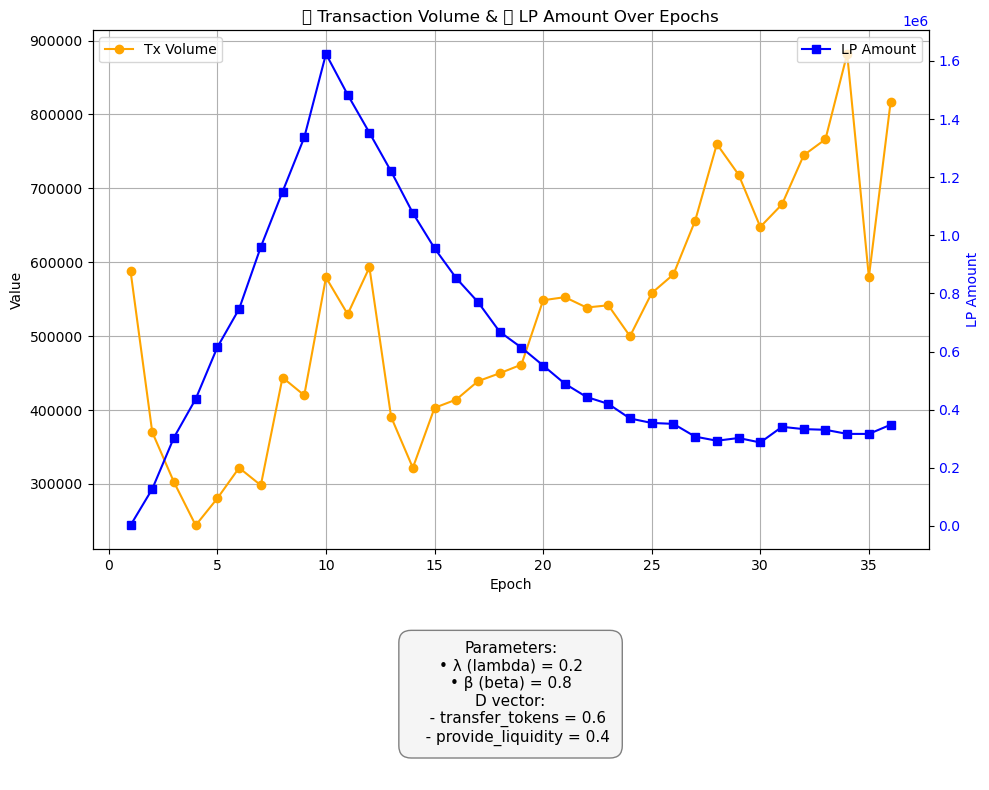

In [51]:
# Get the final system object
final_systems = results_df[results_df['system'].notnull()]
last_system = final_systems.iloc[-1]['system']

# Extract metrics
tx_data = last_system.macro_metrics['monthly_tx_volume_tokens']
lp_data = last_system.macro_metrics['lp_amount']

# Create DataFrame
epochs = sorted(tx_data.keys())
tx_lp_df = pd.DataFrame({
    'epoch': epochs,
    'tx_volume': [tx_data.get(e, 0.0) for e in epochs],
    'lp_amount': [lp_data.get(e, 0.0) for e in epochs]
})

# Plot
fig, axs = plt.subplots(2, 1, figsize=(10, 8), gridspec_kw={'height_ratios': [3, 1]})

# Subplot 1: Tx Volume
axs[0].plot(tx_lp_df['epoch'], tx_lp_df['tx_volume'], marker='o', color='orange', label='Tx Volume')
axs[0].set_title("📈 Transaction Volume & 💧 LP Amount Over Epochs")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Value")
axs[0].grid(True)
axs[0].legend(loc='upper left')

# Plot LP on right y-axis
ax2 = axs[0].twinx()
ax2.plot(tx_lp_df['epoch'], tx_lp_df['lp_amount'], marker='s', color='blue', label='LP Amount')
ax2.set_ylabel("LP Amount", color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.legend(loc='upper right')

# Legend box in Subplot 2
axs[1].axis('off')  # No axes
legend_text = (
    f"Parameters:\n"
    f"• λ (lambda) = {lambda_value}\n"
    f"• β (beta) = {beta_value}\n"
    f"D vector:\n"
    f"   - transfer_tokens = {d_vector['transfer_tokens']}\n"
    f"   - provide_liquidity = {d_vector['provide_liquidity']}"
)
axs[1].text(0.5, 0.5, legend_text,
            horizontalalignment='center',
            verticalalignment='center',
            fontsize=11,
            bbox=dict(facecolor='whitesmoke', edgecolor='gray', boxstyle='round,pad=0.8'))

plt.tight_layout()
plt.savefig("styled_tx_lp_plots.png", dpi=300)
plt.show()


### 11) Governance dynamics — multipliers & activity weights

Each epoch the governance loop nudges activity toward a target mix **D**:

- **Multipliers** (policy output): boost/suppress incentives per activity  
  – e.g., if transfers exceed the target, transfer multiplier drifts ↓ while liquidity multiplier drifts ↑.  
- **Activity weights** (state): the realized share of activity in that epoch (what agents actually did).

📊 Governance Multipliers and Weights per Epoch:
 epoch  tx_multiplier  liq_multiplier  tx_weight  liq_weight
     1         1.7760          1.9800     0.5000      0.5000
     2         1.2342          2.5840     0.9381      0.0619
     3         1.0926          2.8804     0.6159      0.3841
     4         1.0715          2.9361     0.6111      0.3889
     5         1.0344          3.0377     0.5810      0.4190
     6         1.0343          3.0383     0.6163      0.3837
     7         0.9515          3.2813     0.6325      0.3675
     8         0.9678          3.2251     0.6027      0.3973
     9         0.8920          3.4777     0.6065      0.3935
    10         0.8327          3.7091     0.6236      0.3764
    11         0.7928          3.8865     0.6280      0.3720
    12         0.5596          5.0000     0.6679      0.3321
    13         0.5000          5.0000     0.7038      0.2962
    14         0.5000          5.0000     0.4602      0.5398
    15         0.5000          5.0000

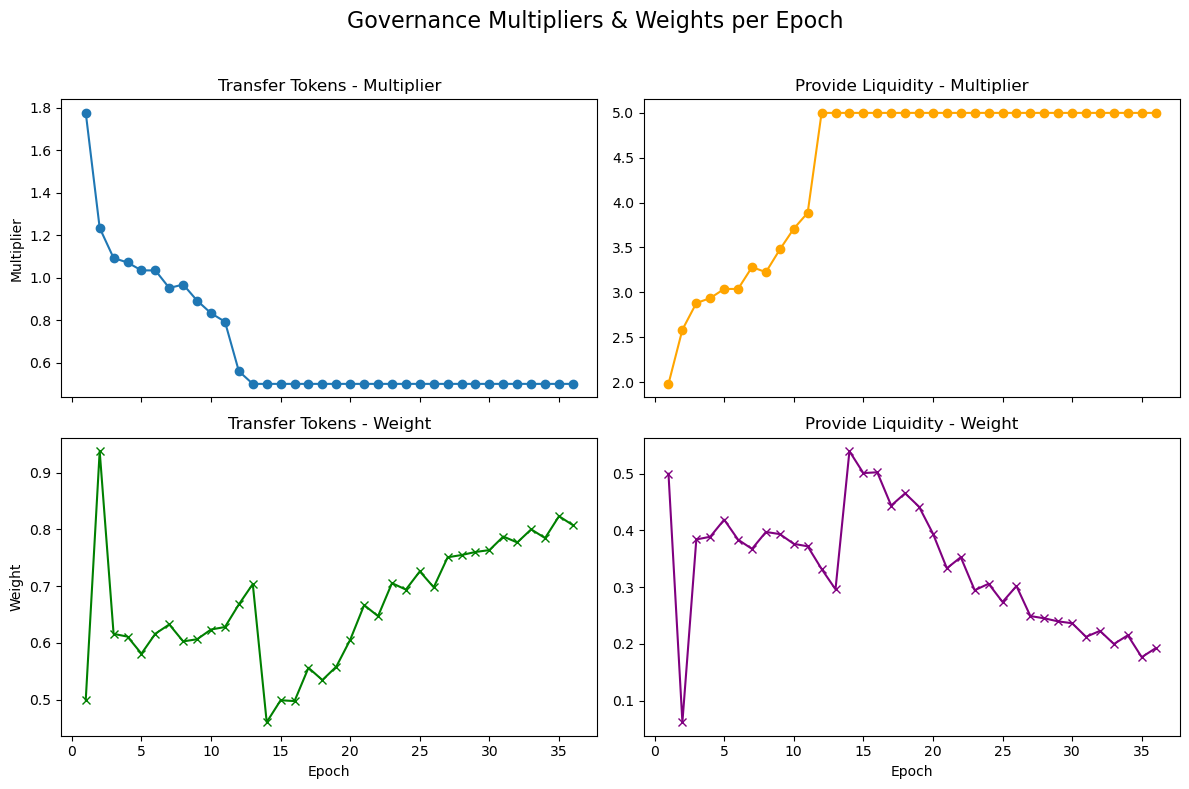

In [31]:
# 🧠 Get last system state
last_epoch = results_df["timestep"].max()
last_system = results_df[results_df["timestep"] == last_epoch]["system"].iloc[0]

# 🧮 Collect governance multipliers and activity weights
rows = []
for epoch in sorted(last_system.epoch_summary.keys()):
    # Multipliers (per-epoch)
    gov_multiplier = last_system.governance_debug_log[epoch - 1]  # 0-indexed list
    multiplier_tx = gov_multiplier.get("transfer_tokens", 0.0)
    multiplier_liq = gov_multiplier.get("provide_liquidity", 0.0)

    # Weights
    activity_weights = last_system.past_activity_weights[epoch - 1]
    weight_tx = activity_weights.get("transfer_tokens", 0.0)
    weight_liq = activity_weights.get("provide_liquidity", 0.0)

    rows.append({
        "epoch": epoch,
        "tx_multiplier": multiplier_tx,
        "liq_multiplier": multiplier_liq,
        "tx_weight": weight_tx,
        "liq_weight": weight_liq
    })

# 📊 Create DataFrame
df_gov = pd.DataFrame(rows)
print("📊 Governance Multipliers and Weights per Epoch:")
print(df_gov.round(4).to_string(index=False))

# 📈 Plotting
fig, axs = plt.subplots(2, 2, figsize=(12, 8), sharex=True)
fig.suptitle("Governance Multipliers & Weights per Epoch", fontsize=16)

# Top row: Multipliers
axs[0, 0].plot(df_gov["epoch"], df_gov["tx_multiplier"], marker='o')
axs[0, 0].set_title("Transfer Tokens - Multiplier")
axs[0, 0].set_ylabel("Multiplier")

axs[0, 1].plot(df_gov["epoch"], df_gov["liq_multiplier"], marker='o', color='orange')
axs[0, 1].set_title("Provide Liquidity - Multiplier")

# Bottom row: Weights
axs[1, 0].plot(df_gov["epoch"], df_gov["tx_weight"], marker='x', color='green')
axs[1, 0].set_title("Transfer Tokens - Weight")
axs[1, 0].set_ylabel("Weight")
axs[1, 0].set_xlabel("Epoch")

axs[1, 1].plot(df_gov["epoch"], df_gov["liq_weight"], marker='x', color='purple')
axs[1, 1].set_title("Provide Liquidity - Weight")
axs[1, 1].set_xlabel("Epoch")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


### 12) Liquidity activity — adds vs removes

We summarize how liquidity providers behaved over time:

- **add_count / amount_added:** how many LP add actions occurred and the total tokens added in that epoch.
- **remove_count / amount_removed:** how many LP removes occurred and the total tokens withdrawn.

**Decision rule.**  
Agents compare the **LP APY** (smoothed by λ) to a **threshold APY**:
- If `LP_APY ≥ APY_threshold` → more agents **add** liquidity.
- If `LP_APY < APY_threshold` → more agents **remove** liquidity (profit-taking or reallocation).

This table shows the realized adds/removes per epoch so we can verify whether behavior follows the APY signal.


In [33]:
# ✅ Step 1: Get the system state from the final timestep in the simulation
last_epoch = results_df["timestep"].max()

# Get the SystemState object from the last timestep
last_system = results_df[results_df["timestep"] == last_epoch]["system"].iloc[0]

# ✅ Step 2: Build liquidity summary from all recorded epochs
all_epochs = sorted(last_system.epoch_summary.keys())

liquidity_summary = []

for epoch in all_epochs:
    add_count = sum(agent.liquidity_add_count_history.get(epoch, 0) for agent in last_system.agents.values())
    remove_count = sum(agent.liquidity_remove_count_history.get(epoch, 0) for agent in last_system.agents.values())
    amount_added = sum(agent.liquidity_added_amount_history.get(epoch, 0.0) for agent in last_system.agents.values())
    amount_removed = sum(agent.liquidity_removed_amount_history.get(epoch, 0.0) for agent in last_system.agents.values())

    liquidity_summary.append({
        'epoch': epoch,
        'add_count': add_count,
        'amount_added': amount_added,
        'remove_count': remove_count,
        'amount_removed': amount_removed
    })

# ✅ Step 3: Convert to DataFrame and display
df_liq = pd.DataFrame(liquidity_summary)

print("📊 Liquidity Activity Summary (per Epoch):")
print(df_liq.round(6).to_string(index=False))


📊 Liquidity Activity Summary (per Epoch):
 epoch  add_count  amount_added  remove_count  amount_removed
     1         32  11202.651629            26     8927.974641
     2        590 127751.792337            23     2753.256651
     3        642 182159.395992            30     5068.527841
     4        778 135343.253261            34     2810.449786
     5        807 186917.066328            38     8512.460137
     6        845 137937.759931            38     6492.000060
     7       1058 217235.830039            41     3606.614678
     8       1169 192196.268256            49     2559.802603
     9       1250 194773.100498            65     7831.336433
    10       1365 298801.814943            68    11401.110582
    11         83  17645.923984          1308   158300.464937
    12         86  26627.526859          1152   157128.020454
    13         98  14781.503906          1137   147960.761784
    14         98  18756.730658          1014   161945.140388
    15         96  37360.321

📈 LP APY per Epoch:
 epoch    lp_apy
     1 62.320430
     2 44.078866
     3 31.060232
     4 21.902243
     5 15.460658
     6 10.938512
     7  7.760807
     8  5.529595
     9  3.964934
    10  2.860936
    11  2.104453
    12  1.584510
    13  1.176740
    14  0.897986
    15  0.709805
    16  0.594426
    17  0.516338
    18  0.470995
    19  0.454102
    20  0.459211
    21  0.469165
    22  0.505376
    23  0.525596
    24  0.558281
    25  0.598628
    26  0.627114
    27  0.699042
    28  0.771728
    29  0.787254
    30  0.830741
    31  0.830560
    32  0.829512
    33  0.833471
    34  0.847105
    35  0.844434
    36  0.825261


C:\Users\KyriakosChristou\AppData\Local\Temp\ipykernel_1692\2676060369.py:49: UserWarning: Glyph 128185 (\N{CHART WITH UPWARDS TREND AND YEN SIGN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\KyriakosChristou\AppData\Local\Temp\ipykernel_1692\2676060369.py:50: UserWarning: Glyph 128185 (\N{CHART WITH UPWARDS TREND AND YEN SIGN}) missing from font(s) DejaVu Sans.
  plt.savefig("lp_apy_plot.png", dpi=300)
C:\Users\KyriakosChristou\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128185 (\N{CHART WITH UPWARDS TREND AND YEN SIGN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


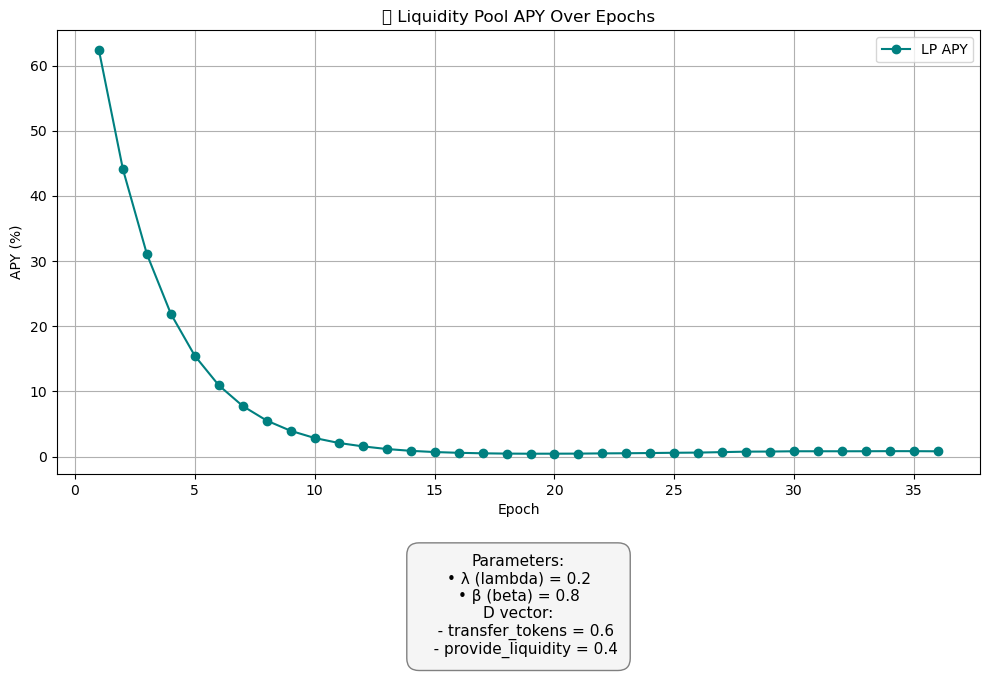

In [53]:
# Get final system
final_systems = results_df[results_df['system'].notnull()]
last_system = final_systems.iloc[-1]['system']

# Extract APY for LP
apy_data = last_system.macro_metrics['apy_lp']
apy_df = pd.DataFrame(list(apy_data.items()), columns=['epoch', 'lp_apy'])
apy_df = apy_df.sort_values('epoch')

# Print the table
print("📈 LP APY per Epoch:")
print(apy_df.round(6).to_string(index=False))

# Plot layout: main plot + parameter box
fig, axs = plt.subplots(2, 1, figsize=(10, 7), gridspec_kw={'height_ratios': [3, 1]})

# Plot: APY line
axs[0].plot(apy_df['epoch'], apy_df['lp_apy'], marker='o', color='teal', label='LP APY')
axs[0].set_title("💹 Liquidity Pool APY Over Epochs")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("APY (%)")
axs[0].grid(True)
axs[0].legend()

# Parameter legend box
axs[1].axis('off')  # Hide axis
legend_text = (
    f"Parameters:\n"
    f"• λ (lambda) = {lambda_value}\n"
    f"• β (beta) = {beta_value}\n"
    f"D vector:\n"
    f"   - transfer_tokens = {d_vector['transfer_tokens']}\n"
    f"   - provide_liquidity = {d_vector['provide_liquidity']}"
)
axs[1].text(0.5, 0.5, legend_text,
            horizontalalignment='center',
            verticalalignment='center',
            fontsize=11,
            bbox=dict(facecolor='whitesmoke', edgecolor='gray', boxstyle='round,pad=0.8'))

plt.tight_layout()
plt.savefig("lp_apy_plot.png", dpi=300)
plt.show()


### 13) LP APY ↔ Liquidity & Rewards

We visualize how **LP APY** evolves and how it relates to:
- **LP amount** (depth of liquidity)
- **Monthly rewards/fees** (the source of APY)

Interpretation:
- When **APY rises above the threshold**, LP tends to **increase** (adds dominate).
- When **APY falls**, LP tends to **decrease** (removes dominate).
- A scatter of **APY vs ΔLP** shows the direct sensitivity of liquidity to the incentive.


In [37]:
# 🧠 Get last system state from simulation results
last_epoch = results_df["timestep"].max()
last_system = results_df[results_df["timestep"] == last_epoch]["system"].iloc[0]

# 🧮 Collect metrics per epoch
rows = []
for epoch in sorted(last_system.epoch_summary.keys()):
    monthly_rewards = last_system.macro_metrics["monthly_rewards"].get(epoch, 0.0)
    lp_amount = last_system.macro_metrics["lp_amount"].get(epoch, 0.0)
    
    rows.append({
        "epoch": epoch,
        "monthly_rewards": monthly_rewards,
        "liquidity_pool": lp_amount
    })

# 📊 Convert to DataFrame and display
df_rewards_lp = pd.DataFrame(rows)
print("📈 Monthly Rewards and LP Amount per Epoch:")
print(df_rewards_lp.round(4).to_string(index=False))


📈 Monthly Rewards and LP Amount per Epoch:
 epoch  monthly_rewards  liquidity_pool
     1             93.7       2274.6770
     2            159.6     127273.2127
     3            172.8     304364.0808
     4            193.8     436896.8843
     5            220.2     615301.4905
     6            240.3     746747.2504
     7            276.6     960376.4657
     8            309.5    1150012.9314
     9            349.4    1336954.6954
    10            385.2    1624355.3998
    11            418.9    1483700.8588
    12            418.0    1353200.3653
    13            228.8    1220021.1074
    14            221.9    1076832.6976
    15            215.3     955550.1782
    16            230.7     852531.3505
    17            214.2     770452.6631
    18            203.0     668161.4452
    19            211.7     613773.0768
    20            216.3     552117.1182
    21            200.4     489494.0789
    22            217.6     443871.0441
    23            200.0     420109.32

### 14) LP APY threshold

The LP APY compare to the LP APY threshold drives the liquidity behavior 


In [39]:
# Get the final epoch number
last_epoch = results_df["timestep"].max()

# Access the system state at the final epoch
system = results_df[results_df["timestep"] == last_epoch]["system"].iloc[0]

# Access the dictionary of thresholds by epoch
thresholds_by_epoch = system.metrics.get("adjusted_lp_threshold", {})

# Format into DataFrame for easy reading
df_thresholds = pd.DataFrame(list(thresholds_by_epoch.items()), columns=["Epoch", "Adjusted_LP_Threshold"])
df_thresholds = df_thresholds.sort_values("Epoch")

print("📉 Adjusted LP Threshold by Epoch:")
print(df_thresholds.round(4).to_string(index=False))


📉 Adjusted LP Threshold by Epoch:
 Epoch  Adjusted_LP_Threshold
     1                 2.5650
     2                 2.5300
     3                 2.4950
     4                 2.4600
     5                 2.4250
     6                 2.3900
     7                 2.3428
     8                 2.2956
     9                 2.2483
    10                 2.2011
    11                 2.1539
    12                 2.1067
    13                 2.0469
    14                 1.9872
    15                 1.9275
    16                 1.8678
    17                 1.8081
    18                 1.7483
    19                 1.6986
    20                 1.6489
    21                 1.5992
    22                 1.5494
    23                 1.4997
    24                 1.4500
    25                 1.4125
    26                 1.3750
    27                 1.3375
    28                 1.3000
    29                 1.2625
    30                 1.2250
    31                 1.1875
    32

### 15) Circulating vs Effective Supply

In this simulation we track two related supply metrics:

- **Circulating Supply**  
  The total number of tokens currently available in the economy (all minted tokens that are not permanently locked or burned).

- **Effective Supply**  
  Defined here as the **circulating supply minus the liquidity pool amount**:  
  \[
  \text{effective\_supply} = \text{circulating\_supply} - \text{lp\_amount}
  \]

  Tokens deposited into liquidity pools are excluded, since they are not directly available for transfers or new allocations.  
  This makes effective supply the “liquid portion” of circulating tokens that is actively usable in the system.



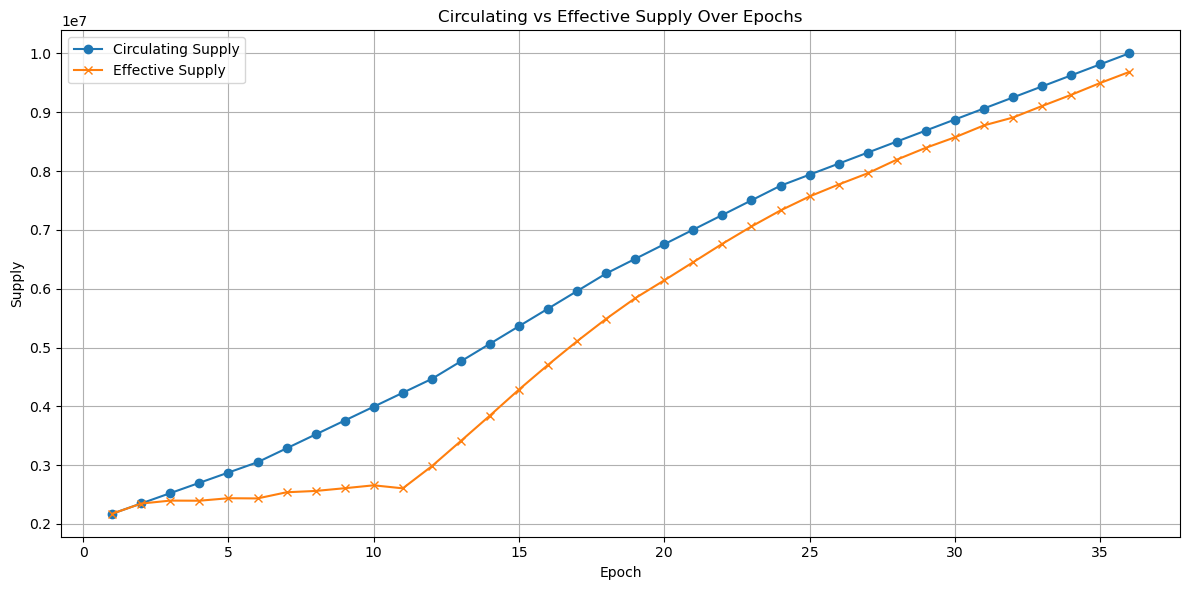


📋 Circulating and Effective Supply per Epoch:
 timestep  circulating_supply  effective_supply
        1        2.175000e+06      2.175000e+06
        2        2.350000e+06      2.347725e+06
        3        2.525000e+06      2.397727e+06
        4        2.700000e+06      2.395636e+06
        5        2.875000e+06      2.438103e+06
        6        3.050000e+06      2.434699e+06
        7        3.286111e+06      2.539364e+06
        8        3.522222e+06      2.561846e+06
        9        3.758333e+06      2.608320e+06
       10        3.994444e+06      2.657490e+06
       11        4.230556e+06      2.606200e+06
       12        4.466667e+06      2.982966e+06
       13        4.765278e+06      3.412077e+06
       14        5.063889e+06      3.843868e+06
       15        5.362500e+06      4.285667e+06
       16        5.661111e+06      4.705561e+06
       17        5.959722e+06      5.107191e+06
       18        6.258333e+06      5.487881e+06
       19        6.506944e+06      5.8387

In [41]:
# Step 1: Build DataFrame from simulation output
results_df = pd.DataFrame(raw_result)

# Step 2: Keep only the final substep per timestep (to avoid duplicate epochs)
filtered_df = results_df[results_df["timestep"] > 0].copy()
filtered_df = filtered_df.sort_values(["timestep", "substep"]).drop_duplicates("timestep", keep="last")

# Step 3: Extract circulating and effective supply from nested structure
def extract_supply(row, key):
    try:
        t = int(row["timestep"])
        return row["supply_metrics"][key].get(t)
    except Exception as e:
        print(f"❌ Failed at timestep {row['timestep']}: {e}")
        return None

filtered_df["circulating_supply"] = filtered_df.apply(lambda row: extract_supply(row, "circulating_supply"), axis=1)
filtered_df["effective_supply"] = filtered_df.apply(lambda row: extract_supply(row, "effective_supply"), axis=1)

# Step 4: Plot both metrics
plt.figure(figsize=(12, 6))
plt.plot(filtered_df["timestep"], filtered_df["circulating_supply"], label="Circulating Supply", marker="o")
plt.plot(filtered_df["timestep"], filtered_df["effective_supply"], label="Effective Supply", marker="x")
plt.xlabel("Epoch")
plt.ylabel("Supply")
plt.title("Circulating vs Effective Supply Over Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 5: Print the values in table form
print("\n📋 Circulating and Effective Supply per Epoch:")
print(filtered_df[["timestep", "circulating_supply", "effective_supply"]].to_string(index=False))


### 16) Adoption, Utility, and Total Agents over Epochs

This section visualizes three critical metrics that reflect the health and dynamics of the simulated blockchain network:

1. **Adoption (left graph)**  
   - **Definition:** Adoption represents the ratio of onboarded agents relative to the maximum potential adoption (logistic-style growth). It is driven primarily by network utility: when utility remains high, more agents are likely to join.  
   - **Observation:** The adoption curve shows a steady upward trend, reflecting continuous onboarding of new participants into the network. This is favorable because it indicates that the system continues to attract agents even as other metrics (like utility) fluctuate.

2. **Utility (middle graph)**  
   - **Definition:** Utility measures how effectively agents use their available capacity (e.g., max transactions and liquidity provision defined by their strategies). High utility means agents are engaging actively and pushing the system toward its maximum operational potential.  
   - **Observation:** Utility begins at a relatively high level but experiences a sharp decline after the early epochs. This drop reflects agents’ strategic withdrawal of activity (e.g., liquidity removal) once returns diminish. After the fall, utility stabilizes at a lower level, meaning the network still operates, but less efficiently compared to the early phase.

3. **Total Agents (right graph)**  
   - **Definition:** Total Agents tracks the cumulative number of active participants in the system (users, developers, bundlers, and miners). New agents are added each epoch according to simulation probabilities, ensuring role balance.  
   - **Observation:** The number of agents grows steadily across epochs, eventually surpassing ~2000 agents in this run. This growth is consistent with the adoption trend, reinforcing that even if utility per agent declines, the network continues expanding its base of participants.

---

### Why These Metrics Matter
- **Adoption** is a proxy for long-term network viability. Sustained adoption ensures demand for tokens, services, and participation.  
- **Utility** signals how engaged agents are relative to their potential capacity. Declining utility can indicate risks of stagnation but may also highlight equilibrium behavior after an initial growth phase.  
- **Total Agents** reflects the system’s expansion. A growing agent base ensures diversity of roles (users, developers, bundlers, miners) and stabilizes network operations.

Together, these three metrics provide a holistic view of **network growth (adoption), efficiency (utility), and scale (total agents).**


 epoch  adoption  utility  total_agents  user  developer  bundler  miner
     1  0.053150 0.221063           331   196         68       33     34
     2  0.058443 0.350568           383   223         78       41     41
     3  0.064017 0.337642           438   254         93       47     44
     4  0.069952 0.330212           497   289        104       53     51
     5  0.076419 0.331292           561   321        123       58     59
     6  0.083305 0.325220           629   361        135       64     69
     7  0.090923 0.332560           705   400        153       71     81
     8  0.099175 0.332751           787   443        172       82     90
     9  0.108244 0.338399           877   494        195       84    104
    10  0.117921 0.334158           973   553        210       92    118
    11  0.125062 0.228851          1044   588        229       99    128
    12  0.132464 0.225499          1118   629        245      110    134
    13  0.135229 0.080187          1145   646      

C:\Users\KyriakosChristou\AppData\Local\Temp\ipykernel_1692\1834387484.py:70: UserWarning: Glyph 127793 (\N{SEEDLING}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\KyriakosChristou\AppData\Local\Temp\ipykernel_1692\1834387484.py:70: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\KyriakosChristou\AppData\Local\Temp\ipykernel_1692\1834387484.py:70: UserWarning: Glyph 128101 (\N{BUSTS IN SILHOUETTE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\KyriakosChristou\AppData\Local\Temp\ipykernel_1692\1834387484.py:72: UserWarning: Glyph 127793 (\N{SEEDLING}) missing from font(s) DejaVu Sans.
  plt.savefig("adoption_utility_agents_final.png", dpi=300)
C:\Users\KyriakosChristou\AppData\Local\Temp\ipykernel_1692\1834387484.py:72: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.savefig("adoption_utility_agents_final.png", dpi=300)
C:\Users\KyriakosChristou\AppData\Local

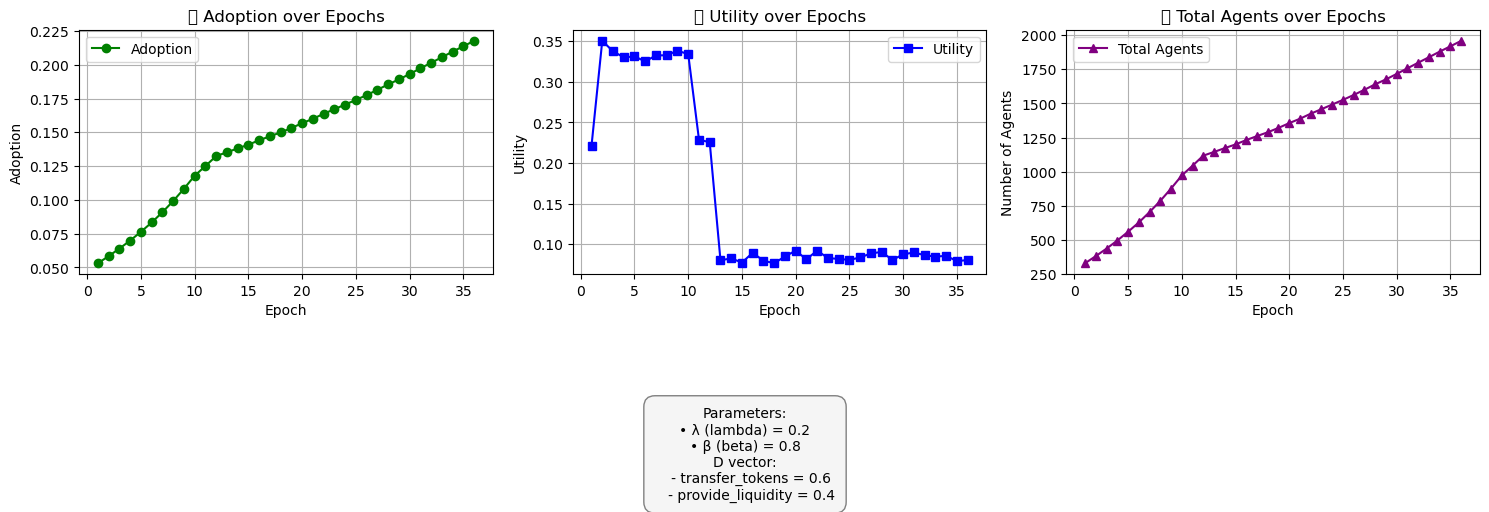

In [59]:
# Get last system
final_systems = results_df[results_df['system'].notnull()]
last_system = final_systems.iloc[-1]['system']

# Load and merge data
summary_df = pd.DataFrame.from_dict(last_system.epoch_summary, orient='index')
summary_df.index.name = 'epoch'
summary_df.reset_index(inplace=True)

agent_df = pd.DataFrame.from_dict(last_system.agent_count_history, orient='index')
agent_df.index.name = 'epoch'
agent_df.reset_index(inplace=True)

full_df = pd.merge(summary_df, agent_df, on='epoch')

# Print table
print(full_df[['epoch', 'adoption', 'utility', 'total_agents', 'user', 'developer', 'bundler', 'miner']].round(6).to_string(index=False))

# Plot subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

# Plot 1: Adoption
axs[0].plot(full_df['epoch'], full_df['adoption'], marker='o', color='green', label='Adoption')
axs[0].set_title("🌱 Adoption over Epochs")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Adoption")
axs[0].grid(True)
axs[0].legend()

# Plot 2: Utility
axs[1].plot(full_df['epoch'], full_df['utility'], marker='s', color='blue', label='Utility')
axs[1].set_title("📊 Utility over Epochs")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Utility")
axs[1].grid(True)
axs[1].legend()

# Plot 3: Total Agents
axs[2].plot(full_df['epoch'], full_df['total_agents'], marker='^', color='purple', label='Total Agents')
axs[2].set_title("👥 Total Agents over Epochs")
axs[2].set_xlabel("Epoch")
axs[2].set_ylabel("Number of Agents")
axs[2].grid(True)
axs[2].legend()

# Add parameter text box below entire figure
legend_text = (
    f"Parameters:\n"
    f"• λ (lambda) = {lambda_value}\n"
    f"• β (beta) = {beta_value}\n"
    f"D vector:\n"
    f"   - transfer_tokens = {d_vector['transfer_tokens']}\n"
    f"   - provide_liquidity = {d_vector['provide_liquidity']}"
)

# Centered below plot
fig.text(0.5, -0.15, legend_text,
         ha='center', va='center',
         fontsize=10,
         bbox=dict(facecolor='whitesmoke', edgecolor='gray', boxstyle='round,pad=0.8'))

plt.tight_layout()
plt.subplots_adjust(bottom=0.3)  # Make space for the legend
plt.savefig("adoption_utility_agents_final.png", dpi=300)
plt.show()


### 17) Reward Distribution per Epoch (Total & by Role)

This chart shows how the **reward pool** evolves over time and how it is **split across roles** (User, Developer, Miner, Bundler).

#### How rewards are generated
- The reward pool is primarily funded by **transaction fees** accumulated each epoch.
- As **transaction volume** rises, fee revenue increases and the total rewards tend to grow; when volume cools or incentives shift, the pool stabilizes at a new level.

#### How rewards are allocated
1) **Fixed role-based splits** (applied every epoch)

2) **Tiered intra-role distribution**  
- Within each role, agents are **ranked by score** and rewards are split by **percentile tiers** (Tier0…Tier4).  
- Higher-tier agents receive larger shares within their role’s slice; **zero-score agents receive no rewards**.  
- Scores for users/developers are smoothed over epochs (λ), while miners/bundlers depend on activity levels and governance signals.

#### What this plot shows
- **Total (blue):** tracks the size of the reward pool across epochs.  
Typical pattern: early growth as volume ramps; later, a **re-leveling** once incentives (e.g., APY vs threshold) change agent behavior and the system finds a new equilibrium.
- **Role lines:** each role’s curve follows the total pool but scaled by fixed splits and **shaped** by tiering (if a role’s active, high-score agents dominate, its line sits nearer the top of its expected slice).
- **User / Developer:** benefit directly from sustained transactional activity and productive participation.
- **Miner / Bundler:** reflect block production / bundling activity and their fee shares.

#### How to read changes
- A **rising total** with proportionate role lines → higher fee generation (often aligned with the rising transaction-volume plot).
- A **sharp step-down** or plateau → a regime change (e.g., LP APY falling below threshold → liquidity outflows, governance multipliers shifting activity mix), after which rewards stabilize.




🎁 Reward Pool and Role Breakdown per Epoch:
 epoch  total_rewards  user_rewards  developer_rewards  miner_rewards  bundler_rewards
     1           93.7        42.165             23.425         23.425            4.685
     2          159.6        71.820             39.900         39.900            7.980
     3          172.8        77.760             43.200         43.200            8.640
     4          193.8        87.210             48.450         48.450            9.690
     5          220.2        99.090             55.050         55.050           11.010
     6          240.3       108.135             60.075         60.075           12.015
     7          276.6       124.470             69.150         69.150           13.830
     8          309.5       139.275             77.375         77.375           15.475
     9          349.4       157.230             87.350         87.350           17.470
    10          385.2       173.340             96.300         96.300           19.260

C:\Users\KyriakosChristou\AppData\Local\Temp\ipykernel_1692\3583299048.py:66: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\KyriakosChristou\AppData\Local\Temp\ipykernel_1692\3583299048.py:68: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.savefig("rewards_distribution_plot.png", dpi=300)
C:\Users\KyriakosChristou\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


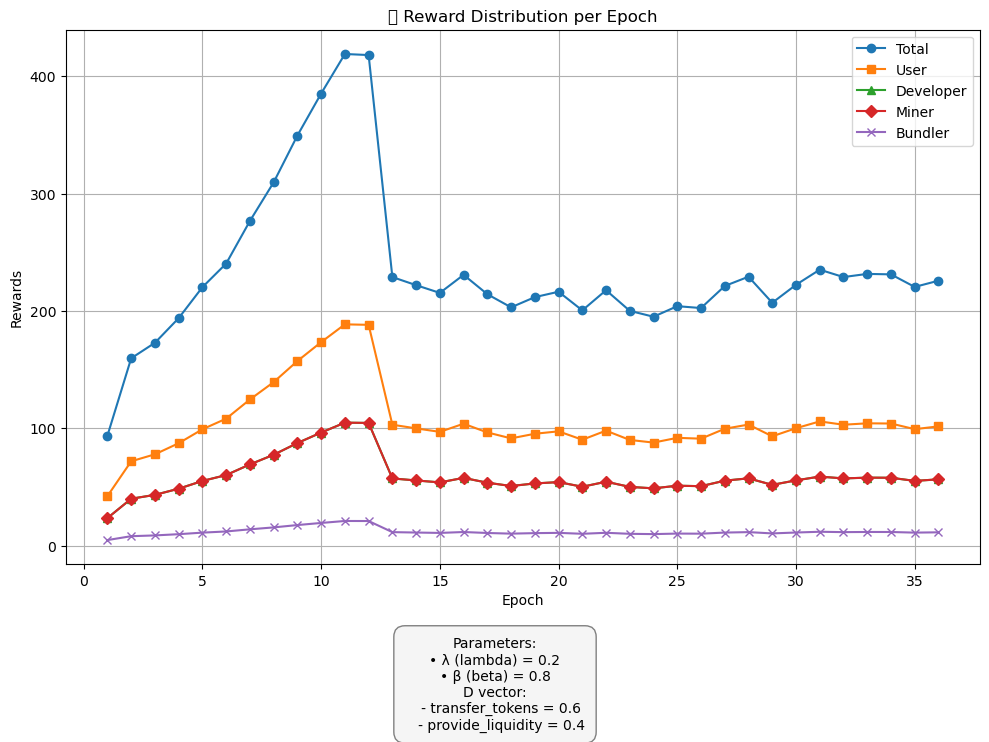

In [69]:
# 🧠 Get last system state
last_epoch = results_df["timestep"].max()
last_system = results_df[results_df["timestep"] == last_epoch]["system"].iloc[0]

# 🧮 Track reward pool and role breakdown
rewards_summary = []

for epoch in sorted(last_system.epoch_summary.keys()):
    total_rewards = sum(
        agent.rewards_earned_history.get(epoch, 0.0)
        for agent in last_system.agents.values()
    )
    role_rewards = last_system.role_rewards_summary.get(epoch, defaultdict(float))
    rewards_summary.append({
        "epoch": epoch,
        "total_rewards": total_rewards,
        "user_rewards": role_rewards.get("user", 0.0),
        "developer_rewards": role_rewards.get("developer", 0.0),
        "miner_rewards": role_rewards.get("miner", 0.0),
        "bundler_rewards": role_rewards.get("bundler", 0.0),
    })

# 📊 Display summary
df_rewards = pd.DataFrame(rewards_summary)
print("🎁 Reward Pool and Role Breakdown per Epoch:")
print(df_rewards.round(4).to_string(index=False))

# 📈 Plot
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(df_rewards['epoch'], df_rewards['total_rewards'], label="Total", marker='o')
ax.plot(df_rewards['epoch'], df_rewards['user_rewards'], label="User", marker='s')
ax.plot(df_rewards['epoch'], df_rewards['developer_rewards'], label="Developer", marker='^')
ax.plot(df_rewards['epoch'], df_rewards['miner_rewards'], label="Miner", marker='D')
ax.plot(df_rewards['epoch'], df_rewards['bundler_rewards'], label="Bundler", marker='x')

ax.set_title("🎯 Reward Distribution per Epoch")
ax.set_xlabel("Epoch")
ax.set_ylabel("Rewards")
ax.grid(True)
ax.legend()

# 📦 Parameters below plot
legend_text = (
    f"Parameters:\n"
    f"• λ (lambda) = {lambda_value}\n"
    f"• β (beta) = {beta_value}\n"
    f"D vector:\n"
    f"   - transfer_tokens = {d_vector['transfer_tokens']}\n"
    f"   - provide_liquidity = {d_vector['provide_liquidity']}"
)
fig.text(0.5, -0.15, legend_text,
         ha='center', va='center',
         fontsize=10,
         bbox=dict(facecolor='whitesmoke', edgecolor='gray', boxstyle='round,pad=0.8'))

plt.tight_layout()
plt.subplots_adjust(bottom=0.05)
plt.savefig("rewards_distribution_plot.png", dpi=300)
plt.show()


### 18) Token Price Over Epochs

This plot shows how the **token price** evolves across epochs as the simulation progresses.

#### How token price is determined
- Token price is derived from the **supply–demand balance** within the system:
  - **Demand drivers:** adoption growth, transaction activity, liquidity provision (which locks tokens), and perceived utility.
  - **Supply side:** effective supply available in circulation (reduced by liquidity lockups and staking).
- Price is recalculated each epoch based on these dynamics and stored in the simulation’s `calculator.metrics`.

#### What this plot shows
- **Early growth:** The price rises in the initial epochs as adoption, activity, and liquidity increase demand faster than circulating supply grows.
- **Peak:** The curve reaches a maximum once demand stabilizes and adoption momentum slows.
- **Decline:** After the peak, the token price falls gradually — this often reflects:
  - Liquidity outflows when LP APY drops below the threshold.
  - A flattening of adoption growth (fewer new participants entering).
  - Transaction volumes stabilizing or decreasing, reducing demand pressure.

#### Why this matters
- Token price provides a **system-wide performance indicator**, aggregating the effects of adoption, utility, liquidity dynamics, and reward distribution.
- In practice, it highlights the **trade-offs in incentive design**: strong initial growth can be followed by corrections if rewards are not sustainable or if adoption saturates.
- The shape of this curve (rise, peak, decline) is typical of systems balancing **short-term incentives** (fast adoption/liquidity inflows) with **longer-term equilibrium** (reduced growth, stabilized supply).

> Parameters shown below the figure (λ, β, D-vector) influence how **agent behavior and activity mix** feed into demand, indirectly shaping the token price trajectory.



📈 Token Price per Epoch:
 epoch  token_price
     1     1.048388
     2     1.074258
     3     1.111886
     4     1.147221
     5     1.203451
     6     1.249987
     7     1.306343
     8     1.376348
     9     1.449079
    10     1.568244
    11     1.615055
    12     1.633585
    13     1.632451
    14     1.621441
    15     1.606424
    16     1.588178
    17     1.568014
    18     1.546225
    19     1.523685
    20     1.501055
    21     1.477855
    22     1.454248
    23     1.430591
    24     1.406595
    25     1.383053
    26     1.359863
    27     1.337022
    28     1.314811
    29     1.292713
    30     1.270523
    31     1.248961
    32     1.227869
    33     1.207098
    34     1.186910
    35     1.166007
    36     1.146321


C:\Users\KyriakosChristou\AppData\Local\Temp\ipykernel_1692\732401946.py:45: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\KyriakosChristou\AppData\Local\Temp\ipykernel_1692\732401946.py:47: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  plt.savefig("token_price_plot.png", dpi=300)
C:\Users\KyriakosChristou\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


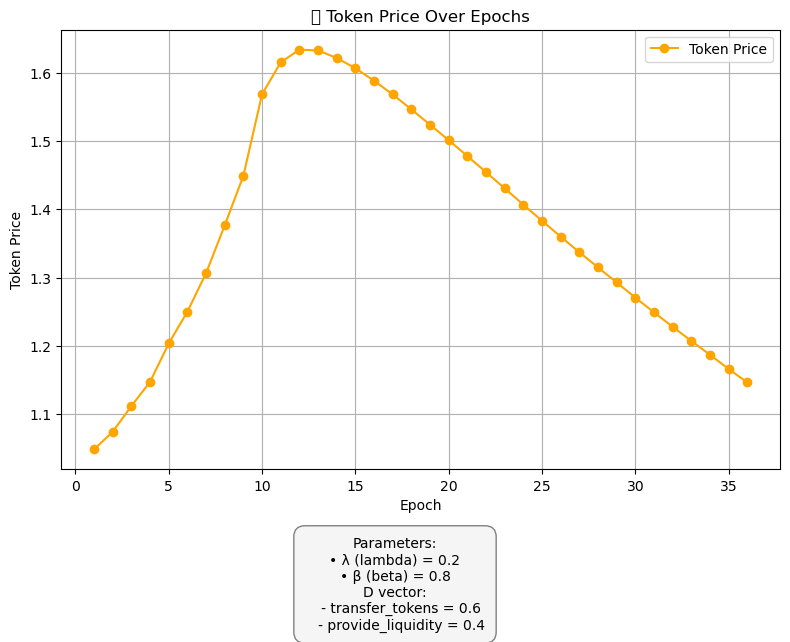

In [67]:
# 📦 Extract token price history
token_price_history = last_system.calculator.metrics['token_price']

# Convert to DataFrame
price_df = pd.DataFrame.from_dict(token_price_history, orient='index', columns=['token_price'])
price_df.index.name = 'epoch'
price_df.reset_index(inplace=True)

# ✅ Print token price table
print("\n📈 Token Price per Epoch:")
print(price_df.round(6).to_string(index=False))

# 📊 Plot
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(price_df['epoch'], price_df['token_price'], marker='o', color='orange', label='Token Price')
ax.set_title("💰 Token Price Over Epochs")
ax.set_xlabel("Epoch")
ax.set_ylabel("Token Price")
ax.grid(True)
ax.legend()

# 📎 Add parameter box below plot
legend_text = (
    f"Parameters:\n"
    f"• λ (lambda) = {lambda_value}\n"
    f"• β (beta) = {beta_value}\n"
    f"D vector:\n"
    f"   - transfer_tokens = {d_vector['transfer_tokens']}\n"
    f"   - provide_liquidity = {d_vector['provide_liquidity']}"
)

fig.text(0.5, -0.18, legend_text,
         ha='center', va='center',
         fontsize=10,
         bbox=dict(facecolor='whitesmoke', edgecolor='gray', boxstyle='round,pad=0.8'))

plt.tight_layout()
plt.subplots_adjust(bottom=0.05)  # More space for the box
plt.savefig("token_price_plot.png", dpi=300)
plt.show()
